In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
print "Done"

Done


In [2]:
pickle_file = 'dataset.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)


('Training set', (45000, 32, 32, 3), (45000,))
('Validation set', (5000, 32, 32, 3), (5000,))
('Test set', (10000, 32, 32, 3), (10000,))


In [3]:
image_size = 32
num_labels = 10
depth = 3

def reformat(dataset, labels):
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (45000, 32, 32, 3), (45000, 10))
('Validation set', (5000, 32, 32, 3), (5000, 10))
('Test set', (10000, 32, 32, 3), (10000, 10))


In [4]:
print 'Training labels shape', train_labels.shape
print 'First label vector', train_labels[0]
print 'Second label vector', train_labels[1]

Training labels shape (45000, 10)
First label vector [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Second label vector [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [6]:
# create a Tensor Weight with a predefined shape
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

# create a Tensor Biases with a predifined shape
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

# perform a convolution using strides of 1 and SAME padding
# reducing the kernel stride to 1 will make the convolutions output images with the same
# size as the original input
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# perform a max pooling operation using stride of 2
# apply max pooling (Windows size 2x2) and Stride of 2 to reduce
# the image dimension by half
def max_pool_2x2(x):
  return tf.nn.max_pool(x, 
                        ksize=[1, 2, 2, 1], # The size of the window for each dimension of the input tensor.
                        strides=[1, 2, 2, 1], # The stride of the sliding window for each dimension of the input 
                        padding='SAME')

In [7]:
import tensorflow as tf

IMAGE_SIZE=32
NUM_LABELS=10
# We'll bundle groups of examples during training for efficiency.
# This defines the size of the batch.
BATCH_SIZE = 60
# We have only one channel in our grayscale images.
NUM_CHANNELS = 3
# The random seed that defines initialization.
SEED = 42

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step, which we'll write once we define the graph structure.
train_data_node = tf.placeholder(
  tf.float32,
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.float32,
                                   shape=(BATCH_SIZE, NUM_LABELS))

# For the validation and test data, we'll just hold the entire dataset in
# one constant node.
validation_data_node = tf.constant(valid_dataset)
test_data_node = tf.constant(test_dataset)

# The variables below hold all the trainable weights. For each, the
# parameter defines how the variables will be initialized.
conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))
conv2_weights = tf.Variable(
  tf.truncated_normal([5, 5, 32, 64],
                      stddev=0.1,
                      seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_SIZE / 4 * IMAGE_SIZE / 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
fc2_weights = tf.Variable(
  tf.truncated_normal([512, NUM_LABELS],
                      stddev=0.1,
                      seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))

print 'Done'

Done


In [8]:
def model(data, train=False):
  """The Model definition."""
  # 2D convolution, with 'SAME' padding (i.e. the output feature map has
  # the same size as the input). Note that {strides} is a 4D array whose
  # shape matches the data layout: [image index, y, x, depth].
  conv = tf.nn.conv2d(data,
                      conv1_weights,
                      strides=[1, 1, 1, 1],
                      padding='SAME')

  # Bias and rectified linear non-linearity.
  relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
  
  # Max pooling. The kernel size spec ksize also follows the layout of
  # the data. Here we have a pooling window of 2, and a stride of 2.
  pool = tf.nn.max_pool(relu,
                        ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1],
                        padding='SAME')
  conv = tf.nn.conv2d(pool,
                      conv2_weights,
                      strides=[1, 1, 1, 1],
                      padding='SAME')
  relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
  pool = tf.nn.max_pool(relu,
                        ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1],
                        padding='SAME')
  
  # Reshape the feature map cuboid into a 2D matrix to feed it to the
  # fully connected layers.
  pool_shape = pool.get_shape().as_list()
  reshape = tf.reshape(
      pool,
      [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
  # Fully connected layer. Note that the '+' operation automatically
  # broadcasts the biases.
  hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
  
  # Add a 50% dropout during training only. Dropout also scales
  # activations such that no rescaling is needed at evaluation time.
  if train:
    hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
  return tf.matmul(hidden, fc2_weights) + fc2_biases

print 'Done'

Done


In [9]:
# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
  logits, train_labels_node))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  4 * BATCH_SIZE,      # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)
# We'll compute them only once in a while by calling their {eval()} method.
validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node))

print 'Done'

Done


In [10]:
# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Initialize all the variables we defined above.
tf.initialize_all_variables().run()

In [11]:
BATCH_SIZE = 60

# Grab the first BATCH_SIZE examples and labels.
batch_data = train_dataset[:BATCH_SIZE, :, :, :]
batch_labels = train_labels[:BATCH_SIZE]

# This dictionary maps the batch data (as a numpy array) to the
# node in the graph is should be fed to.
feed_dict = {train_data_node: batch_data,
             train_labels_node: batch_labels}

# Run the graph and fetch some of the nodes.
_, l, lr, predictions = s.run(
  [optimizer, loss, learning_rate, train_prediction],
  feed_dict=feed_dict)

print 'Done'

Done


In [12]:
print predictions[0]

[  7.00776582e-06   5.22931397e-04   6.66658347e-03   1.11271262e-01
   3.06268851e-03   2.12299358e-02   1.08794849e-02   5.82005130e-04
   1.35196103e-02   8.32258403e-01]


In [13]:

# The highest probability in the first entry.
print 'First prediction', np.argmax(predictions[0])

# But, predictions is actually a list of BATCH_SIZE probability vectors.
print predictions.shape

# So, we'll take the highest probability for each vector.
print 'All predictions', np.argmax(predictions, 1)

First prediction 9
(60, 10)
All predictions [9 2 0 7 4 9 8 0 9 9 9 7 9 8 7 2 7 7 3 9 4 3 7 9 1 9 7 0 9 4 1 8 7 0 7 2 4
 3 7 0 7 7 7 5 7 2 0 7 7 9 2 0 8 8 0 7 9 9 9 2]


In [14]:
print 'Batch labels', np.argmax(batch_labels, 1)

Batch labels [1 1 6 2 8 6 1 2 6 7 7 7 3 1 5 1 4 2 1 7 6 3 3 9 1 5 3 3 3 8 9 0 4 5 5 5 6
 5 5 0 9 1 0 9 6 3 7 1 3 7 9 0 6 1 3 5 4 9 7 8]


0.116666666667
Done.


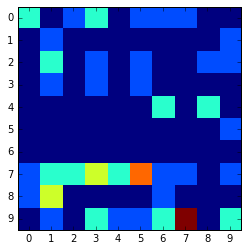

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

correct = np.sum(np.argmax(predictions, 1) == np.argmax(batch_labels, 1))
total = predictions.shape[0]

print float(correct) / float(total)

confusions = np.zeros([10, 10], np.float32)
bundled = zip(np.argmax(predictions, 1), np.argmax(batch_labels, 1))
for predicted, actual in bundled:
  confusions[predicted, actual] += 1

plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');
print "Done."

In [ ]:
def error_rate(predictions, labels):
  """Return the error rate and confusions."""
  correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
  total = predictions.shape[0]

  error = 100.0 - (100 * float(correct) / float(total))

  confusions = np.zeros([10, 10], np.float32)
  bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
  for predicted, actual in bundled:
    confusions[predicted, actual] += 1
    
  return error, confusions

print 'Done'

Done


In [ ]:
# Train over the first 1/4th of our training set.
steps = int(train_labels.shape[0] / BATCH_SIZE)
for step in xrange(steps):
        
  # Compute the offset of the current minibatch in the data.
  # Note that we could use better randomization across epochs.
  offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
  batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
  batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
  # This dictionary maps the batch data (as a numpy array) to the
  # node in the graph is should be fed to.
  feed_dict = {train_data_node: batch_data,
               train_labels_node: batch_labels}
  # Run the graph and fetch some of the nodes.
  _, l, lr, predictions = s.run(
    [optimizer, loss, learning_rate, train_prediction],
    feed_dict=feed_dict)

  # Print out the loss periodically.
  if step % 100 == 0:
    error, _ = error_rate(predictions, batch_labels)
    print 'Step %d of %d' % (step, steps)
    print 'Mini-batch loss: %.5f Error: %.5f Learning rate: %.5f' % (l, error, lr)
    #print 'Validation error: %.1f%%' % error_rate(
    #    validation_prediction.eval(), valid_labels)[0]
    
print 'Validation error: %.1f%%' % error_rate(
      test_prediction.eval(), test_labels)[0]

Step 0 of 750
Mini-batch loss: 9.61714 Error: 85.00000 Learning rate: 0.01000
Step 100 of 750

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
%matplotlib inline
print "Done"

Done


In [21]:
batch_labels = np.array([1,4,3,2,4,5,6,4,3,4,5,7])
predictions = np.array([3,2,4,3,5,6,5,6,7,8,3,4])

correct = np.sum(predictions == batch_labels)
total = predictions.shape[0]

print float(correct) / float(total)

confusions = np.zeros([10, 10], np.float32)
bundled = zip(predictions, batch_labels, 1)
for predicted, actual in bundled:
  confusions[predicted, actual] += 1

plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

0.0


TypeError: zip argument #3 must support iteration